# InfVis project work
---
This Python Script downloads an up-to-date dataset for **Covid-19**, gives first insights on the data and exports the data to the data folder.

The Data is from the **R**obert **K**och **I**nstitut downloaded over [ArcGis Hub](https://hub.arcgis.com/datasets/dd4580c810204019a7b8eb3e0b329dd6?page=15976).

*Script was created on Python: 3.7.6 64-bit Kernel*

## Importing and installing of required packages

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

from datetime import datetime

import io               # file operations
import json

import ssl              # secure client-server connection
import requests         # html-requests

In [2]:
# Uncomment next 2 lines to install jsonmerge
#import sys
#!{sys.executable} -m pip install jsonmerge
from jsonmerge import Merger

## Pulling the data from the internet

### Defining URL´s
URL´s are created from stringconcat.

In [3]:
sourceURL = 'https://services7.arcgis.com/mOBPykOjAyBO2ZKk/arcgis/rest/services/RKI_COVID19/FeatureServer/0/query?'
objectIdsQuery = 'where=1%3D1&returnIdsOnly=true&f=json'
dataSetQuery = 'where=ObjectId+BETWEEN+0+AND+0' # just as an example gets created later dynamically
dataQuery = '&outSR=4326&outFields=IdBundesland,Bundesland,Landkreis,Altersgruppe,AnzahlFall,AnzahlTodesfall,ObjectId,Meldedatum,IdLandkreis,Datenstand,NeuerFall,NeuerTodesfall,Refdatum,NeuGenesen,AnzahlGenesen,IstErkrankungsbeginn&f=json'

In [4]:
jsonMergeSchema = {"properties":{"features":{"mergeStrategy":"append"}}}
dataMerger = Merger(jsonMergeSchema)

### First request
Check local data and Identifies downloadable data.

In [5]:
# TODO check relevance
try:
    fobjectIds = open("../data/fobjectIds.json", "r+")
except FileNotFoundError: 
    fobjectIds = open("../data/fobjectIds.json", "w+")
    print('New File created')
    latestObjectId_old = 0
else:
    print('File found')
    objectIds_old = json.load(fobjectIds)
    fobjectIds.close()
    latestObjectId_old = objectIds_old['objectIds'][len(objectIds_old['objectIds']) - 1]
    print(f'Latest ObjectId: {latestObjectId_old}')

File found
Latest ObjectId: 21808314


In [6]:
objectIdsRequest = requests.get(sourceURL + objectIdsQuery)
objectIdsRequest.status_code

200

In [7]:
objectIds = json.loads(objectIdsRequest.text)

numOfObjectIds = len(objectIds['objectIds'])

objectIdStart = objectIds['objectIds'][0]
objectIdEnd = objectIds['objectIds'][numOfObjectIds - 1]
print(f'Range of ObjectIds: [{objectIdStart}, {objectIdEnd}]')

Range of ObjectIds: [21808315, 21971184]


In [8]:
with open('../data/fobjectIds.json', 'w') as f:
    json.dump(objectIds, f)
    f.close()

### Secound request
Determines eventual limit of data transfered by the server

In [9]:
dataRequest = requests.get(sourceURL + 'where=1%3D1' + dataQuery)
dataRequest.status_code

200

In [10]:
data = json.loads(dataRequest.text)
maxApiRequest = len(data['features'])

neededRequests = math.ceil(numOfObjectIds / maxApiRequest)

print(f'The download will require {neededRequests - 1} more requests due to the server limit of {maxApiRequest} features/request.')

The download will require 32 more requests due to the server limit of 5000 features/request.


Create all requests needed to get the data for every single ObjectId.  
**Ensure the cell above is run before this one is!**  
Otherwise it **WILL** cause data to be duplicated

In [11]:
i = 0
rangeLowerEnd = data['features'][maxApiRequest - 1]['attributes']['ObjectId'] + 1
rangeUpperEnd = rangeLowerEnd + maxApiRequest

while (i < neededRequests - 1): # neededRequests - 1 because of initial download
    dataSetQuery = f'where=ObjectId+BETWEEN+{rangeLowerEnd}+AND+{rangeUpperEnd}'
    temp_sourceURL = sourceURL + dataSetQuery + dataQuery
    #print(i, temp_sourceURL)
    print(i, f'Pulling ObjectIds: [{rangeLowerEnd}, {rangeUpperEnd}]')

    temp_dataRequest = requests.get(temp_sourceURL)
    if (temp_dataRequest.status_code > 200): # stop when a request isn´t working
        print(temp_dataRequest.status_code)
        break

    temp_data = json.loads(temp_dataRequest.text)

    data = dataMerger.merge(data, temp_data)

    temp_dataLength = len(data['features'])
    t_le = data['features'][0]['attributes']['ObjectId']
    t_ue = data['features'][temp_dataLength - 1]['attributes']['ObjectId']
    print(f'Total collected features: {temp_dataLength}', f'From ObjectIds: [{t_le}, {t_ue}]')

    rangeLowerEnd = rangeUpperEnd + 1
    rangeUpperEnd += maxApiRequest + 1
    if (rangeUpperEnd > objectIdEnd):
        rangeUpperEnd = objectIdEnd
    i += 1

print('Done')

0 Pulling ObjectIds: [21813315, 21818315]
Total collected features: 10000 From ObjectIds: [21808315, 21818314]
1 Pulling ObjectIds: [21818316, 21823316]
Total collected features: 15000 From ObjectIds: [21808315, 21823315]
2 Pulling ObjectIds: [21823317, 21828317]
Total collected features: 20000 From ObjectIds: [21808315, 21828316]
3 Pulling ObjectIds: [21828318, 21833318]
Total collected features: 25000 From ObjectIds: [21808315, 21833317]
4 Pulling ObjectIds: [21833319, 21838319]
Total collected features: 30000 From ObjectIds: [21808315, 21838318]
5 Pulling ObjectIds: [21838320, 21843320]
Total collected features: 35000 From ObjectIds: [21808315, 21843319]
6 Pulling ObjectIds: [21843321, 21848321]
Total collected features: 40000 From ObjectIds: [21808315, 21848320]
7 Pulling ObjectIds: [21848322, 21853322]
Total collected features: 45000 From ObjectIds: [21808315, 21853321]
8 Pulling ObjectIds: [21853323, 21858323]
Total collected features: 50000 From ObjectIds: [21808315, 21858322]
9

In [12]:
for item in data['fields']:
    print(item['name'])

IdBundesland
Bundesland
Landkreis
Altersgruppe
AnzahlFall
AnzahlTodesfall
ObjectId
Meldedatum
IdLandkreis
Datenstand
NeuerFall
NeuerTodesfall
Refdatum
NeuGenesen
AnzahlGenesen
IstErkrankungsbeginn


In [13]:
print('Einträge: ', len(data['features']))
print('Aufbau: ', data['features'][0])

Einträge:  162839
Aufbau:  {'attributes': {'IdBundesland': 1, 'Bundesland': 'Schleswig-Holstein', 'Landkreis': 'SK Flensburg', 'Altersgruppe': 'A15-A34', 'AnzahlFall': 1, 'AnzahlTodesfall': 0, 'ObjectId': 21808315, 'Meldedatum': 1584144000000, 'IdLandkreis': '01001', 'Datenstand': '20.07.2020, 00:00 Uhr', 'NeuerFall': 0, 'NeuerTodesfall': -9, 'Refdatum': 1584316800000, 'NeuGenesen': 0, 'AnzahlGenesen': 1, 'IstErkrankungsbeginn': 1}}


In [14]:
totalCases = 0
for entry in data['features']:
    totalCases += entry['attributes']['AnzahlFall']
totalCases

201783

Testing commulated data for comparison with numbers from the internet

In [15]:
shDeaths = 0
shRecovered = 0
shEntries = 0
for entry in data['features']:
    if entry['attributes']['Bundesland'] == 'Schleswig-Holstein':
        shDeaths += entry['attributes']['AnzahlTodesfall']
        shRecovered += entry['attributes']['AnzahlGenesen']
        shEntries += 1
print('Deaths:', shDeaths, 'Recovered:', shRecovered, 'Entries:', shEntries)

Deaths: 155 Recovered: 3046 Entries: 2942


In [16]:
with open('../data/rki_data.json', 'w') as f:
    json.dump(data, f)
    f.close()

## Creating Pandas DataFrame

In [17]:
def display_n(df,n): 
    with pd.option_context('display.max_rows',n*2):
        display(df)

In [18]:
dfx = pd.DataFrame.from_dict(data['features'])
display_n(dfx, 2)

,attributes
0,"{'IdBundesland': 1, 'Bundesland': 'Schleswig-H..."
1,"{'IdBundesland': 1, 'Bundesland': 'Schleswig-H..."
...,...
162837,"{'IdBundesland': 16, 'Bundesland': 'Thüringen'..."
162838,"{'IdBundesland': 16, 'Bundesland': 'Thüringen'..."


In [19]:
# turning the collumn attributes in seperated collumns
for rowid in data['fields']:
    dfx[rowid['name']] = dfx.apply(lambda row: row.loc['attributes'][rowid['name']], axis=1)
dfx = dfx.drop(['attributes'], axis=1)

In [20]:
display_n(dfx, 2)

,IdBundesland,Bundesland,Landkreis,Altersgruppe,AnzahlFall,AnzahlTodesfall,ObjectId,Meldedatum,IdLandkreis,Datenstand,NeuerFall,NeuerTodesfall,Refdatum,NeuGenesen,AnzahlGenesen,IstErkrankungsbeginn
0,1,Schleswig-Holstein,SK Flensburg,A15-A34,1,0,21808315,1584144000000,01001,"20.07.2020, 00:00 Uhr",0,-9,1584316800000,0,1,1
1,1,Schleswig-Holstein,SK Flensburg,A15-A34,1,0,21808316,1584576000000,01001,"20.07.2020, 00:00 Uhr",0,-9,1584057600000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162837,16,Thüringen,LK Altenburger Land,A80+,2,0,21971183,1590624000000,16077,"20.07.2020, 00:00 Uhr",0,-9,1590624000000,0,2,0
162838,16,Thüringen,LK Altenburger Land,A80+,1,0,21971184,1591660800000,16077,"20.07.2020, 00:00 Uhr",0,-9,1591660800000,0,1,0


In [21]:
frame_byBundesland = dfx.groupby(['Bundesland'])['AnzahlFall', 'AnzahlTodesfall', 'AnzahlGenesen'].sum().reset_index()
frame_byBundesland = frame_byBundesland.set_index('Bundesland')

In [22]:
frame_byBundesland

,AnzahlFall,AnzahlTodesfall,AnzahlGenesen
Bundesland,,,
Baden-Württemberg,36334,1837,33953
Bayern,49766,2616,46227
Berlin,8778,221,8265
Brandenburg,3481,167,3277
Bremen,1720,55,1630
Hamburg,5239,261,4936
Hessen,11407,514,10498
Mecklenburg-Vorpommern,806,20,784
Niedersachsen,14027,645,13080


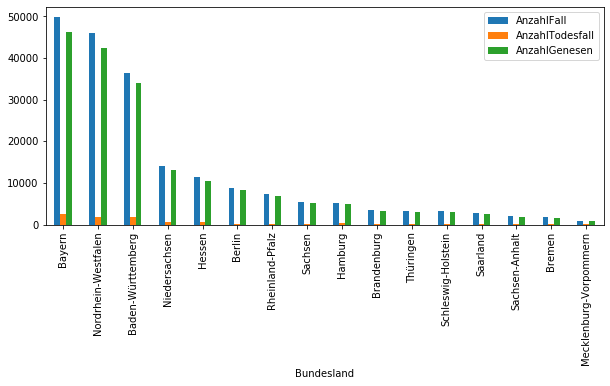

In [23]:
frame_byBundesland = frame_byBundesland.sort_values(by='AnzahlFall', ascending=False)
ax = frame_byBundesland.plot.bar(figsize=(10,4))

---

## Export to CSV

In [24]:
export = dfx.drop(columns=['IdBundesland', 'ObjectId', 'NeuerFall', 'NeuerTodesfall', 'IstErkrankungsbeginn', 'NeuGenesen', 'Meldedatum', 'Datenstand', 'IdLandkreis'])
export.to_csv('../data/rki_covid19_small.csv', index=False, encoding='utf-8')

---

Drop for the visualisation unnessary data

In [25]:
dfx_slim = dfx.drop(columns=['IdBundesland', 'ObjectId', 'NeuerFall', 'NeuerTodesfall', 'IstErkrankungsbeginn', 'NeuGenesen', 'Meldedatum', 'Datenstand', 'IdLandkreis']).groupby(['Refdatum', 'Bundesland', 'Landkreis', 'Altersgruppe']).sum().groupby(['Refdatum', 'Bundesland', 'Landkreis']).sum().groupby(['Refdatum', 'Bundesland']).sum()

In [26]:
dfx_slim

AnzahlFall  AnzahlTodesfall  AnzahlGenesen
Refdatum      Bundesland                                                     
1579046400000 Berlin                        1                0              1
1579219200000 Bayern                        1                1              0
              Schleswig-Holstein            1                0              1
1579478400000 Nordrhein-Westfalen           1                0              1
1579737600000 Bayern                        2                0              2
...                                       ...              ...            ...
1595116800000 Hessen                        3                0              0
              Nordrhein-Westfalen          33                0              0
              Rheinland-Pfalz               1                0              0
              Sachsen-Anhalt                1                0              0
              Schleswig-Holstein            5                0              0

[2317 rows x 3 columns]

In [31]:
dfx_slim.to_csv('../data/rki_slim.csv', index=True, encoding='utf-8')

In [27]:
dfx_slim_cum = dfx_slim.groupby(['Bundesland', 'Refdatum']).sum().groupby(level=[0]).cumsum()
dfx_slim_cum

AnzahlFall  AnzahlTodesfall  AnzahlGenesen
Bundesland        Refdatum                                                 
Baden-Württemberg 1580688000000           1                1              0
                  1580774400000           2                1              1
                  1581292800000           3                1              2
                  1581552000000           4                1              3
                  1581638400000           5                2              3
...                                     ...              ...            ...
Thüringen         1594598400000        3311              182           3092
                  1594684800000        3313              182           3092
                  1594771200000        3317              182           3092
                  1594857600000        3318              182           3092
                  1594944000000        3320              182           3092

[2317 rows x 3 columns]

In [28]:
displayState = "Bayern"
display_n(dfx_slim_cum.groupby(['Bundesland']).get_group(displayState), 10)

AnzahlFall  AnzahlTodesfall  AnzahlGenesen
Bundesland Refdatum                                                 
Bayern     1579219200000           1                1              0
           1579737600000           3                1              2
           1579824000000           4                1              3
           1579910400000           5                1              4
           1580083200000           7                1              6
...                              ...              ...            ...
           1594684800000       49560             2616          46227
           1594771200000       49636             2616          46227
           1594857600000       49685             2616          46227
           1594944000000       49735             2616          46227
           1595030400000       49766             2616          46227

[170 rows x 3 columns]

In [29]:
dfx_slim_cum = dfx_slim_cum.reset_index().set_index('Refdatum')
display_n(dfx_slim_cum, 2)

,Bundesland,AnzahlFall,AnzahlTodesfall,AnzahlGenesen
Refdatum,,,,
1580688000000,Baden-Württemberg,1,1,0
1580774400000,Baden-Württemberg,2,1,1
...,...,...,...,...
1594857600000,Thüringen,3318,182,3092
1594944000000,Thüringen,3320,182,3092


In [30]:
dfx_slim_cum.to_csv('../data/rki_slim_cum.csv', index=True, encoding='utf-8')